#[Aproaching (Almost) Any Machine Learning Problem](https://drive.google.com/file/d/1W5kh2M-fq6l_O0q-Dq028pndv7csLxvu/view?usp=share_link)


In [ ]:
from google.colab import drive
drive.mount('/content/grdrive')

##Supervised vs unsupervised learning

In [4]:
!pip install boruta
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 7.6/7.6 MB 11.6 MB/s eta 0:00:00
     -------------------------------------- 163.0/163.0 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 21.7 MB/s eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB 2.8 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import scipy as sp
import itertools
import copy
import gc
import joblib

from sklearn import ensemble
from sklearn import datasets
from sklearn import decomposition
from sklearn import manifold
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from scipy import sparse
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

%matplotlib inline

In [ ]:
data = datasets.fetch_openml(
                  'mnist_784',
                  version=1,
                  return_X_y=True
)
pixel_values, targets = data
targets = targets.astype(int)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


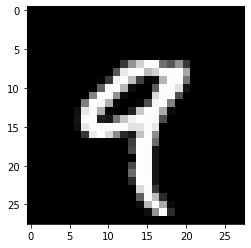

In [ ]:
single_image = pixel_values.iloc[4,:].values.reshape(28,28)
plt.imshow(single_image, cmap='gray')

In [ ]:
tsne = manifold.TSNE(n_components = 2, random_state=42)

transformed_data = tsne.fit_transform(pixel_values.iloc[:3000, :])

In [ ]:
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data, targets[:3000])),
    columns=['x', 'y', 'targets']
)

tsne_df.loc[:, 'targets'] = tsne_df.targets.astype(int)

In [ ]:
tsne_df.head()

,x,y,targets
0,31.722771,-16.391663,5
1,10.612940,-67.804901,0
2,49.593014,38.388294,4
3,-37.814510,32.660255,1
4,22.104887,31.574816,9


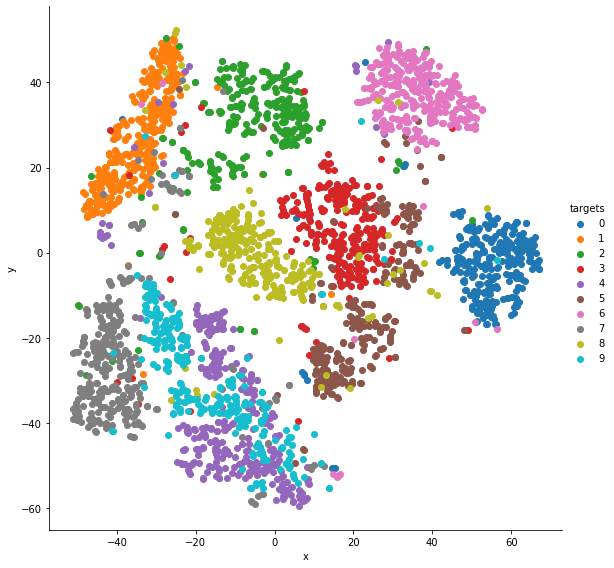

In [ ]:
grid = sns.FacetGrid(tsne_df, hue='targets', height=8)

grid.map(plt.scatter, 'x', 'y').add_legend()

##Boruta

####Toy example

In [ ]:
# make X and y
X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                  'height': [182, 176, 174, 168, 181],
                  'weight': [75, 71, 78, 72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name='income')

####shadow features

In [ ]:
# make X_shadow by randomly permuting each column of X
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['shadow_' + feat for feat in X.columns]

# make X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis=1)

X_boruta.head()

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,32,168,71
1,32,176,71,62,176,75
2,47,174,78,47,174,72
3,51,168,72,25,182,86
4,62,181,86,51,181,78


In [ ]:
# fit a random forest (suggested max_depth between 3 and 7)
forest = RandomForestRegressor(max_depth=5, random_state=42)
forest.fit(X_boruta, y)

# store feature importances
feat_imp_X = forest.feature_importances_[:len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns):]

# compute hits
hits = feat_imp_X > feat_imp_shadow.max()

hits

array([ True, False, False])

In [ ]:
# initialize hits counter
hits = np.zeros((len(X.columns)))

# repeat 20 times
for iter_ in range(20):
    # make X_shadow by randomly permuting each column of X
    X_shadow = X.apply(np.random.permutation)
    X_boruta = pd.concat([X, X_shadow], axis=1)

    # fit a random forest (suggested max_depth between 3 and 7)
    forest = RandomForestRegressor(max_depth=5, random_state=42)
    forest.fit(X_boruta, y)

    # store feature importance
    feat_imp_X = forest.feature_importances_[:len(X.columns)]
    feat_imp_shadow = forest.feature_importances_[len(X.columns):]

    # compute hits for this trial and add to counter

    hits += (feat_imp_X > feat_imp_shadow.max())

hits

array([18.,  5.,  1.])

In [ ]:
trials = 20
pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(trials + 1)]
pmf

[9.5367431640625e-07,
 1.9073486328124993e-05,
 0.00018119812011718736,
 0.0010871887207031228,
 0.004620552062988283,
 0.014785766601562497,
 0.03696441650390628,
 0.07392883300781249,
 0.1201343536376954,
 0.1601791381835938,
 0.17619705200195296,
 0.1601791381835938,
 0.12013435363769538,
 0.07392883300781249,
 0.03696441650390628,
 0.014785766601562497,
 0.004620552062988283,
 0.0010871887207031228,
 0.00018119812011718736,
 1.9073486328124986e-05,
 9.5367431640625e-07]

####BorutaPy in Python

In [ ]:
# initialize Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth=5)
boruta = BorutaPy(estimator=forest, n_estimators='auto', max_iter=100) # max_iter is the number of trials to perform

# fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))

# print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: ['age']


##Cross-validation

In [ ]:
url = 'https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv'
df = pd.read_csv(url)

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [ ]:
#a mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}
"""
you can use the map function of pandas with any dictionary to convert the
values in a fiven column to values in the dictionary
"""
df.loc[:, 'quality'] = df.quality.map(quality_mapping)

In [ ]:
df.shape

(1599, 12)

In [ ]:
"""
use sample with frac=1 to shuffle the dataframe we reset the indices since they
change after shuffling the dataframe
"""
df = df.sample(frac=1).reset_index(drop=True)

# top 1000 rows are selected for training
df_train = df.head(1000)

# bottom 599 are selected for testing/validation
df_test = df.tail(599)

In [ ]:
#initialize decision tree classifier class with a max_depth of 3
clf = tree.DecisionTreeClassifier(max_depth=3)

#choose the columns you want to train on. These are the features for the model
cols = [
        'fixed acidity',
        'volatile acidity',
        'citric acid',
        'residual sugar',
        'chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density',
        'pH',
        'sulphates',
        'alcohol']

#train the model on the provided features and mapped quality from before
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#generate prediction on the training set
train_prediction = clf.predict(df_train[cols])

#generate predictions on the test set
test_predctions = clf.predict(df_test[cols])

#calculate the accuracy of prediction on training dataset
train_accuracy = metrics.accuracy_score(
    df_train.quality, train_prediction
)

#calculate the accuracy of predictions on test data set
test_accuracy = metrics.accuracy_score(
    df_test.quality, test_predctions
)

In [ ]:
print(f'Test accuracy: {test_accuracy * 100}%\nTrain accuracy: {train_accuracy * 100}%')

Test accuracy: 55.926544240400666%
Train accuracy: 61.8%


<function matplotlib.pyplot.show(close=None, block=None)>

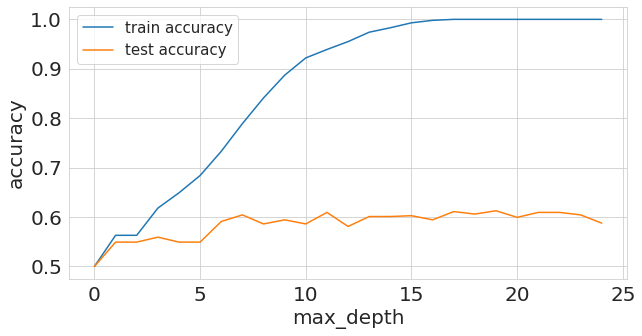

In [ ]:
#this is our global size of label text on the plots
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

"""
initialize lists to store accuracies for trainning and test data we start
with 50% accuracy
"""
train_accuracies = [0.5]
test_accuracies = [0.5]

#iterate over a few depth values
for depth in range(1,25):
  #init the model
  clf = tree.DecisionTreeClassifier(max_depth=depth)
  
  #columns/features for training (this can be done outside the loop)
  cols = [
      'fixed acidity',
      'volatile acidity',
      'citric acid',
      'residual sugar',
      'chlorides',
      'free sulfur dioxide',
      'total sulfur dioxide',
      'density',
      'pH',
      'sulphates',
      'alcohol']
  #fit the model on given features
  clf.fit(df_train[cols], df_train.quality)
  
  #crease training & test predictions
  train_predictions = clf.predict(df_train[cols])
  test_predictions = clf.predict(df_test[cols])

  #calculate training & test accuracies
  train_accuracy = metrics.accuracy_score(
      df_train.quality, train_predictions
  )
  test_accuracy = metrics.accuracy_score(
      df_test.quality, test_predictions
  )

  #append accuracies
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

#create two plots using matplotlib and seaborn
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel('max_depth', size=20)
plt.ylabel('accuracy', size=20)
plt.show

In [ ]:
if __name__ == "__main__":
  # Training data is in a CSV file called train.csv
  df = pd.read_csv("train.csv")
  
  # we create a new column called kfold and fill it with -1
  df["kfold"] = -1

  # the next step is to randomize the rows of the data
  df = df.sample(frac=1).reset_index(drop=True)

  # initiate the kfold class from model_selection module
  kf = model_selection.KFold(n_splits=5)

  # fill the new kfold column
  for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold
  
  # save the new csv with kfold column
  df.to_csv("train_folds.csv", index=False)

In [ ]:
if __name__ == "__main__":
  # Training data is in a CSV file called train.csv
  df = pd.read_csv("train.csv")
  
  # we create a new column called kfold and fill it with -1
  df["kfold"] = -1

  # the next step is to randomize the rows of the data
  df = df.sample(frac=1).reset_index(drop=True)

  #fetch targets
  y = df.target.values

  # initiate the kfold class from model_selection module
  kf = model_selection.StratifiedKFold(n_splits=5)

  # fill the new kfold column
  for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f
  
  # save the new csv with kfold column
  df.to_csv("train_folds.csv", index=False)

Text(0, 0.5, 'count')

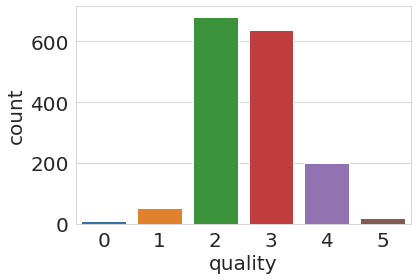

In [ ]:
b = sns.countplot(x='quality', data=df)
b.set_xlabel('quality', fontsize=20)
b.set_ylabel('count', fontsize=20)

In [ ]:
def create_folds(data):
  #we create a new column called kfold and fill it with -1
  data['kfold']= -1

  #the next step is to randomize the rows of the data
  data = data.sample(frac=1).reset_index(drop=True)

  """
  calculate the number of bins by Sturge's rule. I take the floor of the
  value, you can also. Just round it
  """
  num_bins = int(np.floor(1 + np.log2(len(data))))

  #bin targets
  data.loc[:, 'bins'] = pd.cut(
      data['target'], bins = num_bins, labels= False
  )

  # initiate the kfold class from model_selection module
  kf = model_selection.StratifiedKFold(n_splits=5)

  #initiate the kfolds column. Note that, instead of targets, we use bins!
  for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
    data.loc[v_, 'kfold'] = f

  #drop the bins column
  data = data.drop('bins', axis=1)
  #return dataframe with folds
  return data

if __name__ == '__main__':
  #we create a sample dataset with 15000 samples and 100 features and 1 target
  X, y = datasets.make_regression(
      n_samples= 15000, n_features=100, n_targets=1
  )

  #create a dataframe out of our numpy arrays
  df = pd.DataFrame(
      X,
      columns=[f'f_{i}' for i in range(X.shape[1])]
  )
  df.loc[:, 'target'] = y
  
  #create folds
  df = create_folds(df)

In [ ]:
df.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,target,kfold
0,0.833883,-1.212763,-2.118919,0.008524,0.987685,1.460466,-0.379751,1.255613,-0.361635,1.638243,...,1.530479,1.396882,-1.248730,-1.150795,0.627374,0.920017,-2.140182,-1.169375,102.979182,0
1,1.056107,-1.487390,-0.562869,1.766218,0.823910,-0.552589,1.197468,1.660850,1.144910,0.954850,...,-1.091290,-0.949295,-0.304387,-0.930046,1.272153,0.059695,-0.326876,0.119545,-31.765500,0
2,0.904165,-0.953305,-0.299432,-0.996563,-0.081056,0.040106,0.123134,-0.906838,-0.433678,-0.998577,...,-1.129196,-0.096994,-1.118347,0.672859,-1.244522,-1.116674,0.070246,-0.007746,-461.703686,0
3,0.708910,1.234494,1.636877,0.000811,-0.191723,-0.330869,-0.518986,0.104624,-0.707882,-0.708924,...,0.478896,0.229370,-1.378255,1.150957,0.218985,0.562369,1.922340,0.296366,-283.195323,0
4,0.919274,1.419954,-0.573019,-0.651125,-0.721695,-0.563334,1.435880,0.684468,2.713798,-0.531023,...,1.185805,-0.184803,-0.290692,0.528943,-0.850622,-0.510719,1.012844,-0.126850,207.691291,0


In [ ]:
df.kfold.unique()

array([0, 1, 2, 3, 4])

## Evaluation metrics

In [ ]:
def accuracy(y_true, y_pred):
  """
  Function to calculate accuracy
  :param y_true: list of true values
  :param y_pred: list of predcted values
  :return: accuracy score
  """
  #initialize a simple counter for correcte predctions
  correct_counter = 0
  #loop over all elements of y_true and y_pred "together"
  for yt, yp in zip(y_true, y_pred):
    if yt == yp:
      #if prediction is equal to truth, increase the counter
      correct_counter += 1
  
  #return accuracy, which is correct predictions over the number os samples
  return correct_counter/len(y_true)

In [ ]:
def true_positive(y_true, y_pred):
  """
  Function to calculate True Positives
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: number of true positives
  """
  #initialize
  tp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 1:
      tp += 1
  return tp 

def true_negative(y_true, y_pred):
  """
  Function to calculate True Negatives
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: numver of true negatives
  """
  #itinialize
  tn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 0:
      tn += 1
  return tn

def false_positive(y_true, y_pred):
  """
  Function to calculate False Positives
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: number of true negatives
  """
  #initialize
  fp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 1:
      fp += 1;
  return fp

def false_negative(y_true, y_pred):
  """
  Function to calculate Negative
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: number of false negatives
  """
  #initialize
  fn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 0:
      fn += 1;
  return fn

---
\begin{align}
       Accuracy Score = \frac{TP + TN}{TP + TN + FP + FN}
    \end{align}

In [ ]:
def accuracy_v2(y_true, y_pred):
  """
  Function to calculate acuracy using tp/tn/fp/fn
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: accuracy score
  """
  tp = true_positive(y_true, y_pred)
  tn = true_negative(y_true, y_pred)
  fp = false_positive(y_true, y_pred)
  fn = false_negative(y_true, y_pred)
  accuracy_score = (tp + tn)/(tp + tn + fp + fn)
  return accuracy_score

l1 = [0, 1, 1, 1, 0, 0, 0, 1]
l2 = [0, 1, 0, 1, 0, 1, 0, 0]

print(accuracy(l1, l2))
print(accuracy_v2(l1, l2))
print(metrics.accuracy_score(l1, l2))

0.625
0.625
0.625


----
\begin{align}
       Precision = \frac{TP}{TP + FP}
    \end{align}

In [ ]:
def precision(y_true, y_pred):
  """
  Function to calculate precision
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: precision score
  """
  tp = true_positive(y_true, y_pred)
  fp = false_positive(y_true, y_pred)
  precision = tp / (tp + fp)
  return precision

l1 = [0, 1, 1, 1, 0, 0, 0, 1]
l2 = [0, 1, 0, 1, 0, 1, 0, 0]

print(precision(l1, l2))

0.6666666666666666


----
\begin{align}
       Recall = \frac{TP}{TP + FN}
    \end{align}

In [ ]:
def recall(y_true, y_pred): 
  """
  Function to calculate recall
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: recall score
  """
  tp = true_positive(y_true, y_pred)
  fn = false_negative(y_true, y_pred)
  recall = tp / (tp + fn)
  return recall

l1 = [0, 1, 1, 1, 0, 0, 0, 1]
l2 = [0, 1, 0, 1, 0, 1, 0, 0]

print(recall(l1, l2))

0.5


---
\begin{align}
  F1 = \frac{2PR}{P + R} = \frac{2TP}{2TP + FP + FN}
\end{align}

In [ ]:
def f1(y_true, y_pred):
  """
  Function to calculate f1 score
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: f1 score
  """
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)

  score = 2 * p * r / (p + r)
  return score

y_true = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 
          1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
y_pred = [0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
          1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

print(f1(y_true, y_pred))
print(metrics.f1_score(y_true, y_pred))

0.5714285714285715
0.5714285714285715


---
**True Positive Rate(TPR)** also known as sensitivity
\begin{align}
       TPR = \frac{TP}{TP + FN}
    \end{align}

In [ ]:
def tpr(y_true, y_pred):
  """
  Function to calculate tpr
  :param y_true: list of true values
  :param y_pred: list of predicted values
  """
  return recall(y_true, y_pred)

---
**False Positive Rate (FPR) also known as Specificity**
\begin{align}
  FPR = \frac{FP}{TN + FP}
\end{align}

In [ ]:
def fpr(y_true, y_pred):
  """
  Function to calculate fpr
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: fpr
  """
  fp = false_positive(y_true, y_pred)
  tn = true_negative(y_true, y_pred)
  return fp / (tn + fp)

In [ ]:
#empty lists to store tpr and fpr values
tpr_list = []
fpr_list = []

#actual targets
y_true = [0, 0, 0, 0, 1, 0, 1,
          0, 0, 1, 0, 1, 0, 0, 1]

#predicted probabilities of a sample being 1
y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05,
          0.9, 0.5, 0.3, 0.66, 0.3, 0.2,
          0.85, 0.15, 0.99]

#handmade thresholds
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5,
               0.6, 0.7, 0.8, 0.85, 0.9, 0.99, 1.0]

#loop over the thresholds
for thresh in thresholds:
  #calculate predictions for a fiven threshold
  temp_pred = [1 if x >= thresh else 0 for x in y_pred]
  #calculate tpr
  temp_tpr = tpr(y_true, temp_pred)
  #calculate fpr
  temp_fpr = fpr(y_true, temp_pred)
  #append tpr and fpr to lists
  tpr_list.append(temp_tpr)
  fpr_list.append(temp_fpr)

i = 0
for thr, tp, fpr in zip(thresholds, tpr_list, fpr_list):
  print(f'{i} - . {thr} . {tp} . {fpr}')
  i += 1

0 - . 0 . 1.0 . 1.0
1 - . 0.1 . 1.0 . 0.9
2 - . 0.2 . 1.0 . 0.7
3 - . 0.3 . 0.8 . 0.6
4 - . 0.4 . 0.8 . 0.3
5 - . 0.5 . 0.8 . 0.3
6 - . 0.6 . 0.8 . 0.2
7 - . 0.7 . 0.6 . 0.1
8 - . 0.8 . 0.6 . 0.1
9 - . 0.85 . 0.4 . 0.1
10 - . 0.9 . 0.4 . 0.0
11 - . 0.99 . 0.2 . 0.0
12 - . 1.0 . 0.0 . 0.0


**Receiver Operating Characteristic (ROC)**

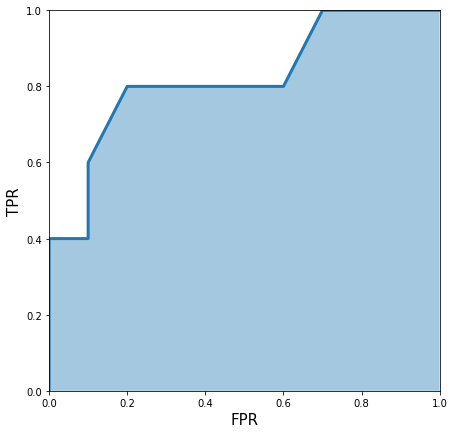

In [ ]:
plt.figure(figsize=(7, 7))
plt.fill_between(fpr_list, tpr_list, alpha=0.4)
plt.plot(fpr_list, tpr_list, lw=3)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.show()

---
**Log Loss**
\begin{align}
  \text{Log Loss} = - 1.0 \times (target \times log(prediction) + (1-target) \times log(1-prediction))
\end{align}

In [ ]:
import numpy as np

def log_loss(y_true, y_proba):
  """
  Function to calculate log loss
  :param y_true: list of true values
  :param y_proba: list of probabilities for 1
  :return: overall log loss
  """
  #define an epsilon value. This can also be an input. This value is used
  #clip probabilities
  epsilon = 1e-15
  #initialize empty list to store individual losses
  loss = []
  #loop over all true and predicted probabilitiy values
  for yt, yp in zip(y_true, y_proba):
    #adjust probability. 0 gets converted to 1e-15. 1 gets converted to 1-1e15
    #why? meia noite eu te conto
    yp = np.clip(yp, epsilon, 1 - epsilon)
    #calculate loss for one sample
    temp_loss = -1 * (yt * np.log(yp) + (1 - yt) * np.log(1-yp))
    #add to loss list
    loss.append(temp_loss)
  
  #return mean loss over all samples
  return np.mean(loss)

y_true = [0, 0, 0, 0, 1, 0, 1,
          0, 0, 1, 0, 1, 0, 0, 1]

y_proba = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05,
           0.9, 0.5, 0.3, 0.66, 0.3, 0.2,
           0.85, 0.15, 0.99]
print(log_loss(y_true, y_proba))
print(metrics.log_loss(y_true, y_proba))

0.49882711861432294
0.49882711861432294


### Macro Precision, Micro Precision & Weighted precision

In [ ]:
import numpy as np

def macro_precision(y_true, y_pred):
  """
  Function to calculate macro averaged precision
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: macro precision score
  """
  # find the number of classes by taking
  # length of unique values in true list
  num_classes = len(np.unique(y_true))

  # initialize precision to 0
  precision = 0

  # loop over all classes
  for class_ in range(num_classes):
    # all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]

    # calculate true positive for current class
    tp = true_positive(temp_true, temp_pred)
    
    # calculate false positive for current class
    fp = false_positive(temp_true, temp_pred)

    # calculate precision for current class
    temp_precision = tp / (tp + fp)
    
    # keep adding precision for all classes
    precision += temp_precision
  # calculate and return average precision over all classes
  precision /= num_classes
  return precision

In [ ]:
import numpy as np

def micro_precision(y_true, y_pred):
  """
  Function to calculate micro averaged precision
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: micro precision score
  """
  
  #find the number of classes by taking the legth of unique values in true list
  num_classes = len(np.unique(y_true))

  #initialize tp and fp to -
  tp = 0
  fp = 0

  #loop over all classes
  for class_ in range(num_classes):
    #all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]
    
    #calculate true positive for current class and update overal tp
    tp += true_positive(temp_true, temp_pred)

    #calculate false positive for current class and update overal fp
    fp += false_positive(temp_true, temp_pred)

  #calculate and return overal precision
  precision = tp / (tp + fp)
  return precision

In [ ]:
from collections import Counter
import numpy as np

def weighted_precision(y_true, y_pred):
  """
  Function to calculate wighted averaged precision
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: weighted precision score
  """

  #find number of classes by taking lenghth of unique values in true list
  num_classes = len(np.unique(y_true))

  #create class:sample count dictionary. it looks something like this:
  #{0:20, 1:15, 2: 21}
  class_counts = Counter(y_true)

  #initialize precision to 0
  precision = 0

  #loop over all classes
  for class_ in range(num_classes):
    #all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]

    #calculate tp and fp for class
    tp = true_positive(temp_true, temp_pred)
    fp = false_positive(temp_true, temp_pred)

    #calculate precision of class
    temp_precision = tp / (tp + fp)

    #multiply precision with count of samples in class
    weighted_precision = class_counts[class_] * temp_precision

    #add to overall precision
    precision += weighted_precision
  #calculate overall precision by dividing by total number of samples
  overall_precision = precision / len(y_true)

  return overall_precision

In [ ]:
from sklearn import metrics

y_true = [0, 1, 2, 0, 1, 2, 0, 2, 2]
y_pred = [0, 2, 1, 0, 2, 1, 0, 0, 2]

print(macro_precision(y_true,y_pred))
print(metrics.precision_score(y_true, y_pred, average='macro'))
print('--------')
print(micro_precision(y_true, y_pred))
print(metrics.precision_score(y_true, y_pred, average='micro'))
print('--------')
print(weighted_precision(y_true, y_pred))
print(metrics.precision_score(y_true, y_pred, average='weighted'))
print('--------')

0.3611111111111111
0.3611111111111111
--------
0.4444444444444444
0.4444444444444444
--------
0.39814814814814814
0.39814814814814814
--------


###Weighted F1


In [ ]:
from collections import Counter
from sklearn import metrics
import numpy as np

def weighted_f1(y_true, y_pred):
  """
   Function to calculate wighted f1 score
  :param y_true: list of true values
  :param y_pred: list of predicted values
  :return: weighted f1 score
  """
  #find number of classes by taking lenghth of unique values in true list
  num_classes = len(np.unique(y_true))

  #create class:sample count dictionary. it looks something like this:
  #{0:20, 1:15, 2: 21}
  class_counts = Counter(y_true)

  #initialize precision to 0
  f1 = 0

  #loop over all classes
  for class_ in range(num_classes):
    #all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]

    #calculate precision and recall for class
    p = precision(temp_true, temp_pred)
    r = recall(temp_true, temp_pred)

    #calculate f1 of class
    if p + r != 0:
      temp_f1 = 2 * p * r / (p + r)
    else:
      temp_f1 = 0
    
    #multiply f1 with count of samples in class
    weighted_f1 = class_counts[class_] * temp_f1

    #add to f1 precision
    f1 += weighted_f1

  #caclulate overall F1 by dividing by total number of samples
  overall_f1 = f1 / len(y_true)
  return overall_f1

y_true = [0, 1, 2, 0, 1, 2, 0, 2, 2]
y_pred = [0, 2, 1, 0, 2, 1, 0, 0, 2]

print(weighted_f1(y_true, y_pred))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

0.41269841269841273
0.41269841269841273


Text(0.5, 48.5, 'Predicted Labels')

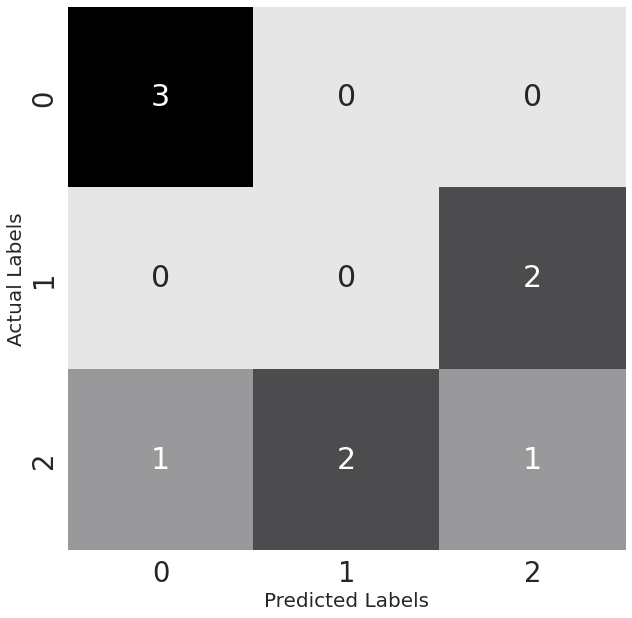

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#some targets and predictions
y_true = [0, 1, 2, 0, 1, 2, 0, 2, 2]
y_pred = [0, 2, 1, 0, 2, 1, 0, 0, 2]

#get confusion matrix from sklearn
cm = metrics.confusion_matrix(y_true, y_pred)

#plot using matplotlib and seaborn
plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.set(font_scale=2.5)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False)
plt.ylabel('Actual Labels', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=20)

In [ ]:
def pk(y_true, y_pred, k):
  """
  This function calculates precision at k
  for a single sample
  :param y_true: list of values, actual classes
  :param y_pred: list of values, predicted classes
  :param k: the value for k
  :return: precision at a given value k
  """
  # if k is 0, return 0. we should never have this
  # as k is always >= 1
  if k == 0:
    return 0
  # we are interested only in top-k predictions
  y_pred = y_pred[:k]
  # convert predictions to set
  pred_set = set(y_pred)
  # convert actual values to set
  true_set = set(y_true)
  # find common values
  common_values = pred_set.intersection(true_set)
  # return length of common values over k
  return len(common_values) / len(y_pred[:k])

In [ ]:
def apk(y_true, y_pred, k):
  """
  This function calculates average precision at k
  for a single sample
  :param y_true: list of values, actual classes
  :param y_pred: list of values, predicted classes
  :return: average precision at a given value k
  """
  # initialize p@k list of values
  pk_values = []
  # loop over all k. from 1 to k + 1
  for i in range(1, k + 1):
    # calculate p@i and append to list
    pk_values.append(pk(y_true, y_pred, i))
    # if we have no values in the list, return 0
  if len(pk_values) == 0:
    return 0
    # else, we return the sum of list over length of list
  return sum(pk_values) / len(pk_values)

In [ ]:
y_true = [
    [1, 2, 3],
    [0, 2],
    [1],
    [2, 3],
    [1, 0],
    []]
y_pred = [
    [0, 1, 2],
    [1],
    [0, 2, 3],
    [2, 3, 4, 0],
    [0, 1, 2],
    [0]]
for i in range(len(y_true)):
  for j in range(1, 4):
    print(f"""
    y_true={y_true[i]},
    y_pred={y_pred[i]},
    AP@{j}={apk(y_true[i], y_pred[i], k=j)}""")



    y_true=[1, 2, 3],
    y_pred=[0, 1, 2],
    AP@1=0.0

    y_true=[1, 2, 3],
    y_pred=[0, 1, 2],
    AP@2=0.25

    y_true=[1, 2, 3],
    y_pred=[0, 1, 2],
    AP@3=0.38888888888888884

    y_true=[0, 2],
    y_pred=[1],
    AP@1=0.0

    y_true=[0, 2],
    y_pred=[1],
    AP@2=0.0

    y_true=[0, 2],
    y_pred=[1],
    AP@3=0.0

    y_true=[1],
    y_pred=[0, 2, 3],
    AP@1=0.0

    y_true=[1],
    y_pred=[0, 2, 3],
    AP@2=0.0

    y_true=[1],
    y_pred=[0, 2, 3],
    AP@3=0.0

    y_true=[2, 3],
    y_pred=[2, 3, 4, 0],
    AP@1=1.0

    y_true=[2, 3],
    y_pred=[2, 3, 4, 0],
    AP@2=1.0

    y_true=[2, 3],
    y_pred=[2, 3, 4, 0],
    AP@3=0.8888888888888888

    y_true=[1, 0],
    y_pred=[0, 1, 2],
    AP@1=1.0

    y_true=[1, 0],
    y_pred=[0, 1, 2],
    AP@2=1.0

    y_true=[1, 0],
    y_pred=[0, 1, 2],
    AP@3=0.8888888888888888

    y_true=[],
    y_pred=[0],
    AP@1=0.0

    y_true=[],
    y_pred=[0],
    AP@2=0.0

    y_true=[],
    y_pred=[0],
    AP@3=0.0


In [ ]:
def mapk(y_true, y_pred, k):
  """
  This function calculates mean avg precision at k
  for a single sample
  :param y_true: list of values, actual classes
  :param y_pred: list of values, predicted classes
  :return: mean avg precision at a given value k
  """
  # initialize empty list for apk values
  apk_values = []
  # loop over all samples
  for i in range(len(y_true)):
    # store apk values for every sample
    apk_values.append(
        apk(y_true[i], y_pred[i], k=k)
    )
  # return mean of apk values list
  return sum(apk_values) / len(apk_values)
for i in range (1, 4):
  print(mapk(y_true, y_pred, k = i))

0.3333333333333333
0.375
0.3611111111111111


###Regression Metrics
####Mean Absolute Error (MAE)

$
\text{Absolute Error} = Abs(True\ Value - Predicted\ Value)
$

In [ ]:
def mean_absolute_error(y_true, y_pred):
    """
    This functino calculates mae.
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: mean absolute error
    """
    # initialize error at 0
    error = 0
    # loop over all samples in the true and predicted list
    for yt, yp in zip(y_true, y_pred):
        # calculate absolute error and add to error
        error += np.abs(yt - yp)
    # return mean error
    return error / len(y_true)

$
Squared\ Error = (True\ Value - Predicted\ Value)^2
$

In [ ]:
def mean_squared_error(y_true, y_pred):
    """
    This function calculate MSE
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: mean squared error
    """
    # initialize error at 0
    error = 0
    # loop over all samples in the true and predicted list
    for yt, yp in zip(y_true, y_pred):
        # calculate squared error and add to error
        error += (yt - yp) ** 2
    # return mean error
    return error / len(y_true)

Squared Logarithmic Error

In [ ]:
def mean_squared_log_error(y_true, y_pred):
    """
    This function calculates msle
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: mean squared logarithmic error
    """

    # initialze error at 0
    error = 0
    # loop over all samples in true and predicted list
    for yt, yp in zip(y_true, y_pred):
        # calculate squared log error and add to error
        error += (np.log(1 + yt) - np.log(1 + yp)) ** 2
    # return mean error
    return error / len(y_true)

$
\text{Percentage Error} = \frac{True\ Value - Predicted\ Value}{True\ Value} * 100
$

In [ ]:
def mean_percentage_error(y_true,y_pred):
    """
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: mean percentage error
    """
    # initialize error at 0
    error = 0

    # loop over all samples in true and predicted list
    for yt, yp in zip(y_true, y_pred):
        # calculate percentage error and add to error
        error += (yt - yp) / yt
    # return mean percentage error
    return error / len(y_true) 

Mean Absolute Percentage Error(MAPE)

In [ ]:
def mean_abs_percentage_error(y_true, y_pred):
    """
    This function calculates MAPE
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: mean absolute percentage error
    """
    #initialize error at 0
    error = 0
    # loop ober all samples in true and predicted list
    for yt, yp in zip(y_true, y_pred):
        # calculate percentage error and add to error
        error += np.abs(yt - yp) / yt
    # return mean percentage error
    return error / len(y_true)

$
R^2 = 1 - \frac{\sum^N_{i=1}(y_{t_i} - y_{p_i})^2}{(y_{t_i} - y_{p_{mean}})^2}
$

In [ ]:
def r2(y_true, y_pred):
    """
    This function calulates r-squared score
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :return: r2 score
    """

    # calculate the mean value of true values
    mean_true_value = np.mean(y_true)

    # initialize numerator with 0
    numerator = 0
    # initialize denomiator with 0
    denominator = 0

    # loop over all true and predicted values
    for yt, yp in zip(y_true, y_pred):
        # update numerator
        numerator += (yt - yp) ** 2
        # update denominator
        denominator += (yt - mean_true_value) ** 2
    # calculate the ratio
    ratio = numerator - denominator
    # return 1 - ratio
    return 1 - ratio

In [ ]:
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
y_true = [1, 2, 3, 1, 2, 3, 1, 2, 3]
y_pred = [2, 1, 3, 1, 2, 3, 3, 1, 2]

print(metrics.cohen_kappa_score(y_true, y_pred, weights="quadratic"))
print(metrics.accuracy_score(y_true, y_pred))

0.33333333333333337
0.4444444444444444


Matthew's Correlation Coefficient (MCC)
$
MCC = \frac{TP \times TN - FP \times FN}{[(TP + FP)\times(FN + TN)\times(FP + TN)\times(TP + FN)]^{0,5}}
$

In [ ]:
def mcc(y_true, y_pred):
    """
    This function calculates Matthew's Correlation Coefficient
    for binary classification.
    :param y_true: list of true values
    :param y_pred: list of predicted values
    :return: mcc score
    """
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)

    numerator = tp * tn - fp * fn
    denominator = (
        (tp + fp) *
        (fn + tn) *
        (fp + tn) *
        (tp + fn)
    )

    denominator = denominator ** 0.5

    return numerator / denominator

##Approaching categorical variables

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/grdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cat-in-the-dat-ii

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 80% 33.0M/41.3M [00:00<00:00, 38.4MB/s]
100% 41.3M/41.3M [00:00<00:00, 46.0MB/s]


In [ ]:
!unzip cat-in-the-dat-ii.zip

Archive:  cat-in-the-dat-ii.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_cat = pd.read_csv('/content/train.csv')
df_cat.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


Text(0, 0.5, 'count')

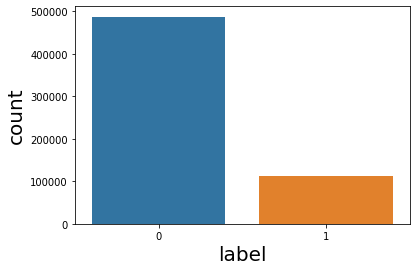

In [ ]:
c = sns.countplot(x='target', data=df_cat)
c.set_xlabel('label', fontsize=20)
c.set_ylabel('count', fontsize=20)

###Label Encoding

In [ ]:
mapping = {
    'Freezing' : 0,
    'Warm' : 1,
    'Cold' : 2,
    'Boiling Hot': 3,
    'Hot' : 4,
    'Lava Hot' : 5
}

df_cat.loc[:, 'ord_2'] = df_cat.ord_2.map(mapping)

In [ ]:
df_cat.ord_2.value_counts()

0.0    142726
1.0    124239
2.0     97822
3.0     84790
4.0     67508
5.0     64840
Name: ord_2, dtype: int64

In [ ]:
from sklearn import preprocessing

#fill NaN values in ord_2 column
df_cat.loc[:, 'ord_2'] = df_cat.ord_2.fillna('NONE')

#initilize LabelEncoder()
lbl_enc = preprocessing.LabelEncoder()

#fit label encoder and transform values in ord_2 column
#do not use this directly, fit first, then transform
df_cat.loc[:, "ord_2"] = lbl_enc.fit_transform(df_cat.ord_2.values)

In [ ]:
#create our example feature matrix
example = np.array(
    [ 
      [0, 0, 1],
      [1, 0, 0],
      [1, 0, 1]
    ]
)

#print size in bytes
print(example.nbytes)

#convert numpy array to sparse CSR matrix
sparse_example = sparse.csr_matrix(example)

print(sparse_example.data.nbytes)

#print size of this sparse matrix
print(sparse_example.data.nbytes +
      sparse_example.indptr.nbytes +
      sparse_example.indices.nbytes
)


72
32
64


In [ ]:
#number of rows
n_rows = 10000

#number of columns
n_cols = 10000

#create random binary matrix with only %5 values as 1s
example = np.random.binomial(1, p=0.05, size=(n_rows, n_cols))

#print size in bytes
print(f'Size of dense array: {example.nbytes}')

#convert numpy array to sparce CRS matrx
sparse_example = sparse.csr_matrix(example)

#print size of this sparse matrix
print(f'Size of sparse array: {sparse_example.data.nbytes}')

full_size = (sparse_example.data.nbytes +
      sparse_example.indptr.nbytes +
      sparse_example.indices.nbytes
)

#print full size of this sparse matrix
print(f'Full size of sparse array: {full_size}')

Size of dense array: 800000000
Size of sparse array: 40019024
Full size of sparse array: 60068540


####One Hot Encoding
**One Hot Encoding** is a binary encoding in the sense that there are only two values, 0s and 1s. However, it must be noted that **it's not a binary representation**.

In [ ]:
#create binary matrix
example = np.array(
    [
        [0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]
    ]
)

# print size in bytes
print(f"Size of dense array: {example.nbytes}")

# convert numpy array to sparse CSR matrix
sparse_example = sparse.csr_matrix(example)

# print size of this sparse matrix
print(f"Size of sparse array: {sparse_example.data.nbytes}")

full_size = (
    sparse_example.data.nbytes +
    sparse_example.indptr.nbytes +
    sparse_example.indices.nbytes
)

# print full size of this sparse matrix
print(f"Full size of sparse array: {full_size}")

Size of dense array: 144
Size of sparse array: 24
Full size of sparse array: 52


In [ ]:
#create random 1-d array with 1001 different categories(int)
example = np.random.randint(1000, size=1000000)

#initialize OneHotEncoder from scikit-learn
#keep sparse = False to get dense array
ohe = preprocessing.OneHotEncoder(sparse=False)

#fit and transform data with dense one hot encoder
ohe_example = ohe.fit_transform(example.reshape(-1, 1))

#print size in bytes for dense array
print(f'Size of dense array: {ohe_example.nbytes}')

#initialize OneHotEncoder from scikit-learn. Keep sparse = True to get sparse array
ohe = preprocessing.OneHotEncoder(sparse=True)

#fit and transform data with sparce one-hot encoder
ohe_example = ohe.fit_transform(example.reshape(-1, 1))

#print size of this sparce matrix
print(f'Size of sparse array: {ohe_example.data.nbytes}')

full_size = (ohe_example.data.nbytes + ohe_example.indptr.nbytes +
             ohe_example.indices.nbytes
            )
#print full size of this sparse matrix
print(f'Full size of Sparse array: {full_size}')

Size of dense array: 8000000000
Size of sparse array: 8000000
Full size of Sparse array: 16000004


In [ ]:
df_cat[df_cat.ord_2 == 'Boiling Hot'].shape

(84790, 25)

In [ ]:
df_cat.groupby(['ord_2'])['id'].count()

ord_2
Boiling Hot     84790
Cold            97822
Freezing       142726
Hot             67508
Lava Hot        64840
Warm           124239
Name: id, dtype: int64

In [ ]:
df_cat.groupby(['ord_2'])['id'].transform('count')

0          67508.0
1         124239.0
2         142726.0
3          64840.0
4          97822.0
            ...   
599995    142726.0
599996     84790.0
599997    142726.0
599998    124239.0
599999     84790.0
Name: id, Length: 600000, dtype: float64

In [ ]:
df_cat.groupby(['ord_1', 'ord_2'])['id'].count().reset_index(name='count')

,ord_1,ord_2,count
0,Contributor,Boiling Hot,15634
1,Contributor,Cold,17734
2,Contributor,Freezing,26082
3,Contributor,Hot,12428
4,Contributor,Lava Hot,11919
5,Contributor,Warm,22774
6,Expert,Boiling Hot,19477
7,Expert,Cold,22956
8,Expert,Freezing,33249
9,Expert,Hot,15792


In [ ]:
df_cat['new_feature'] = (df_cat.ord_1.astype(str) + '_' + df_cat.ord_2.astype(str))
df_cat.new_feature

0                 Contributor_Hot
1                Grandmaster_Warm
2                    nan_Freezing
3                 Novice_Lava Hot
4                Grandmaster_Cold
                   ...           
599995            Novice_Freezing
599996         Novice_Boiling Hot
599997       Contributor_Freezing
599998                Master_Warm
599999    Contributor_Boiling Hot
Name: new_feature, Length: 600000, dtype: object

In [ ]:
df_cat['new_feature'] = (df_cat.ord_1.astype(str) + '_' +
                     df_cat.ord_2.astype(str) + '_' +
                     df_cat.ord_3.astype(str))
df_cat.new_feature

0                 Contributor_Hot_c
1                Grandmaster_Warm_e
2                    nan_Freezing_n
3                 Novice_Lava Hot_a
4                Grandmaster_Cold_h
                    ...            
599995            Novice_Freezing_a
599996         Novice_Boiling Hot_n
599997       Contributor_Freezing_n
599998                Master_Warm_m
599999    Contributor_Boiling Hot_b
Name: new_feature, Length: 600000, dtype: object

Whenever you get categorical variables, follow these simple steps:
* fill the NaN values (this is very important!)
* convert them to integers by applying label encoding using LabelEncoder of scikit-learn or by using a mapping dictionary;
* create one-hot encoding;
* go for modelling.

In [ ]:
df_cat.ord_2.value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
Name: ord_2, dtype: int64

In [ ]:
df_cat.ord_2.fillna('NONE'). value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
NONE            18075
Name: ord_2, dtype: int64

In [6]:
#read train data
train = pd.read_csv('train.csv')

#read test data
test = pd.read_csv('test.csv')

#create a fake target column for test data. Since this column doesn't exist
test.loc[:, 'target'] = -1

#concatenate both training and test data
data = pd.concat([train, test]).reset_index(drop=True)

#make a list of features we are interested in.
#id and target is something we should not encode
features = [x for x in train.columns if x not in ['id, target']]

#loop over the features list
for feat in features:
    #create a new instace of LabelEncoder for each feature
    lbl_enc = preprocessing.LabelEncoder()

    #note the trick here: since its categorical data, we fillna with a string and
    #we convert all the data to string type so, no matter its int or float, its
    #converted to string int/float but categorical!!!
    temp_col = data[feat].fillna('NONE').astype(str).values

    #we can use fit_transform here as we do not have any extra test data that we
    #need to transform on separately
    data.loc[:, feat] = lbl_enc.fit_transform(temp_col)

#split the training and test data again
train = data[data.target != -1].reset_index(drop=True)
test = data[data.target == -1].reset_index(drop=True)

C:\Users\rafel\AppData\Local\Temp\ipykernel_14288\339629752.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, feat] = lbl_enc.fit_transform(temp_col)
C:\Users\rafel\AppData\Local\Temp\ipykernel_14288\339629752.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, feat] = lbl_enc.fit_transform(temp_col)
C:\Users\rafel\AppData\Local\Temp\ipykernel_14288\339629752.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old b

In [ ]:
df_cat.ord_4.fillna('None').value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
None    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
G        3404
V        3107
J        1950
L        1657
Name: ord_4, dtype: int64

In [ ]:
df_cat.ord_4 = df_cat.ord_4.fillna('NONE')

df_cat.loc[
    df_cat['ord_4'].value_counts()[df_cat['ord_4']].values < 2000, 'ord_4'
] = 'RARE'

df_cat.ord_4.value_counts()

N       39978
P       37890
Y       36657
A       36633
R       33045
U       32897
M       32504
X       32347
C       32112
H       31189
Q       30145
T       29723
O       25610
B       25212
E       21871
K       21676
I       19805
NONE    17930
D       17284
F       16721
W        8268
Z        5790
S        4595
RARE     3607
G        3404
V        3107
Name: ord_4, dtype: int64

In [ ]:
#read training data
df = pd.read_csv('train.csv')

# we create a new column called kfold and fill it with -1
df['kfold'] = -1

#the next step is to randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

#fetch labels
y = df.target.values

#initiate the kfold class from model_selection module
kf = model_selection.StratifiedKFold(n_splits=5)

#fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

#save the new csv with kfold column
df.to_csv('cat_train_folds.csv', index=False)

In [ ]:
teste_df = pd.read_csv('cat_train_folds.csv')
teste_df.kfold.value_counts()

0    120000
1    120000
2    120000
3    120000
4    120000
Name: kfold, dtype: int64

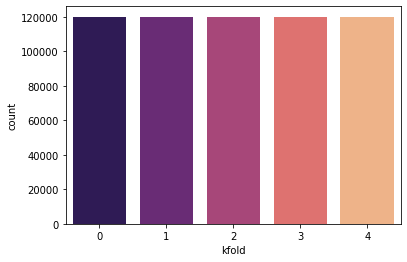

In [ ]:
sns.countplot(x='kfold', data=teste_df, palette='magma')
plt.show()

In [ ]:
for i in range(5):
    print(f'fold {i}:\n{teste_df[df.kfold == i].target.value_counts()}')

fold 0:
0    97536
1    22464
Name: target, dtype: int64
fold 1:
0    97536
1    22464
Name: target, dtype: int64
fold 2:
0    97535
1    22465
Name: target, dtype: int64
fold 3:
0    97535
1    22465
Name: target, dtype: int64
fold 4:
0    97535
1    22465
Name: target, dtype: int64


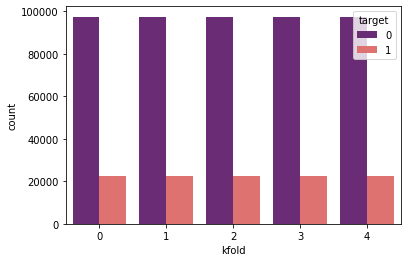

In [ ]:
sns.countplot(x='kfold', hue='target', data=teste_df, palette='magma')
plt.show()

In [ ]:
def run(fold):
    #load the full training data with folds
    df = pd.read_csv('cat_train_folds.csv')

    #all columns are features except id, target and kfold columns
    features = [f for f in df.columns if f not in ('id', 'target', 'kfold')]

    #fill all NaN values with NONE. Note that I am converting all columns to
    # 'strings' it doesn't matter becouse all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')

    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # initialize OneHotEncoder from sk-learn
    ohe = preprocessing.OneHotEncoder()
    
    # fit ohe on training + validation features
    full_data = pd.concat([df_train[features], df_valid[features]], axis=0)
    ohe.fit(full_data[features])

    # transform training data
    x_train = ohe.transform(df_train[features])
    
    # transform validation data
    x_valid = ohe.transform(df_valid[features])

    # initialize Logistic Regression model
    model = linear_model.LogisticRegression()

    # fit model on training data (ohe)
    model.fit(x_train, df_train.target.values)

    # predict on validation data. We need the probability values as we are
    # calculating AUC we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get ROC AUC score
    auc = metrics.roc_auc_score(df_valid.target.values, valid_preds)

    # print auc
    print(f'Fold = {fold}, AUC = {auc}')

In [ ]:
for fold_ in range(5):
    run(fold_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7867289781615006


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7849130637125262


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7858448475828346


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7860020299400933


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7861940305038222


In [ ]:
def run(fold):
    # load the full training data with folds
    df = pd.read_csv('cat_train_folds.csv')

    # all columns are features except id, targed and kfold columns
    features = [f for f in df.columns if f not in ('id', 'target', 'kfold')]

    # fill all NaN values with NONE. Note that I'm converting all columns to 
    # 'strings'. It doesn't matter because all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')
    
    # now its time to label encode the features
    for col in features:
        # initialize LabelEncoder for each feature column
        lbl = preprocessing.LabelEncoder()

        # fit label encoder on all data
        lbl.fit(df[col])

        # transform all data
        df.loc[:, col] = lbl.transform(df[col])
    
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    #initialize random forest model
    model = ensemble.RandomForestClassifier(n_jobs=-1)

    #fit model on training data (ohe)
    model.fit(x_train, df_train.target.values)

    # predict on validation data. We need the probability values as we are
    # calculatin AUC. We will use probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.target.values, valid_preds)

    # print auc
    print(f'Fold = {fold}, AUC = {auc}')

In [ ]:
for fold_ in range(5):
    run(fold_) 

Fold = 0, AUC = 0.7178963980254819
Fold = 1, AUC = 0.7165300625832186
Fold = 2, AUC = 0.7168569623594176
Fold = 3, AUC = 0.7156983737716962
Fold = 4, AUC = 0.7159167368351886


In [ ]:
def run(fold):
    # load the full training data with folds
    df = pd.read_csv('cat_train_folds.csv')

    # all columns are features except id, target, and kfold columns
    features = [f for f in df.columns if f not in ('id', 'target', 'kfold')]

    # fill all NaN values with NONE. Note that I'm converting all columns to
    # 'strings'. It doesn't matter because all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')

    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # initialize OneHotEncoder from scikit-learn
    ohe = preprocessing.OneHotEncoder()

    # fit ohe on training + validation features
    full_data = pd.concat([df_train[features], df_valid[features]], axis=0)
    ohe.fit(full_data[features])

    # transform training data
    x_train = ohe.transform(df_train[features])
    print(f'Shape do conjunto de treino:{x_train.shape}')
    # transform validation data
    x_valid = ohe.transform(df_valid[features])

    # initialize Truncated SVD. We are reducing the data to 120 components
    svd = decomposition.TruncatedSVD(n_components=120)

    # fit svd on full sparse training data
    full_sparse = sparse.vstack((x_train, x_train))
    svd.fit(full_sparse)

    # transform sparse training data
    x_train = svd.transform(x_train)
    print(f'Shape do conjunto de treino:{x_train.shape}')
    # transform sparse validation data
    x_valid = svd.transform(x_valid)

    # initialize random forest model
    model = ensemble.RandomForestClassifier(n_jobs=-1)

    # fit model on training data (ohe)
    model.fit(x_train, df_train.target.values)

    # predict on validation data. We need the probability values as we are
    # calculating AUC. We will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics. roc_auc_score(df_valid.target.values, valid_preds)

    # print AUC
    print(f'Fold = {fold}, AUC:{auc}')


In [ ]:
for fold_ in range(5):
    run(fold_)

Shape do conjunto de treino:(480000, 5723)
Shape do conjunto de treino:(480000, 120)
Fold = 0, AUC:0.7083552598199113
Shape do conjunto de treino:(480000, 5723)
Shape do conjunto de treino:(480000, 120)
Fold = 1, AUC:0.7066197618854938
Shape do conjunto de treino:(480000, 5723)
Shape do conjunto de treino:(480000, 120)
Fold = 2, AUC:0.7063384020831959
Shape do conjunto de treino:(480000, 5723)
Shape do conjunto de treino:(480000, 120)
Fold = 3, AUC:0.7060884910529531
Shape do conjunto de treino:(480000, 5723)
Shape do conjunto de treino:(480000, 120)
Fold = 4, AUC:0.7040569166385865


In [ ]:
def run(fold):
    # load the full training data with folds
    df = pd.read_csv('cat_train_folds.csv')

    # all collumns are features except id, target and kfold columns
    features = [f for f in df.columns if f not in ('id', 'target', 'kfold')]

    # fill all NaN values with NONE. Note that I am converting all columns to 
    # 'strings'. It doesn't matter because all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')

    # now it's time to label encode the features
    for col in features:

        # initialize LabelEncoder for each feature column
        lbl = preprocessing.LabelEncoder()

        # fit label encoder on all data
        lbl.fit(df[col])

        # transform all the data
        df.loc[:, col] = lbl.transform(df[col])
    
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(
        n_jobs=-1,
        max_depth=7,
        n_estimators=200
    )

    # fit model on training data (ohe)
    model.fit(x_train, df_train.target.values)

    # predict on validation data. We need the probability values as we are
    # calculating AUC we will use the probality of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.target.values, valid_preds)

    # print auc
    print(f'Fold = {fold}, AUC = {auc}')

In [ ]:
for fold_ in range(5):
    run(fold_) 0,7665627605327754 + 0,7638472654417088 + 0,7645713449026859 + 0,765239702627023 + 0,7643385330890311

Fold = 0, AUC = 0.7665627605327754
Fold = 1, AUC = 0.7638472654417088
Fold = 2, AUC = 0.7645713449026859
Fold = 3, AUC = 0.765239702627023
Fold = 4, AUC = 0.7643385330890311


#### US adult census data

In [1]:
! kaggle datasets download -d uciml/adult-census-income
! unzip adult-census-income.zip

'kaggle' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [3]:
df = pd.read_csv('adult.csv')
df.income.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

Cross-Validation:

In [4]:
# we create a new column called kfold and fill it with -1
df['kfold'] = -1

# the next step is to randomize the rows of the data
df = df.sample(frac=1).reset_index(drop=True)

# fetch labels
y = df.income.values

# initiate the kfold class from model_selection module
kf = model_selection.StratifiedKFold(n_splits=5)

# fill the new kfold column
for f, (t_,v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv('adult_folds.csv', index=False)

df = pd.read_csv('adult_folds.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,kfold
0,33,Private,143582,HS-grad,9,Separated,Other-service,Unmarried,Asian-Pac-Islander,Female,0,0,48,China,<=50K,0
1,24,Local-gov,193416,Some-college,10,Never-married,Protective-serv,Own-child,White,Female,0,0,40,United-States,<=50K,0
2,35,Private,30381,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K,0
3,46,State-gov,72506,HS-grad,9,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,40,United-States,<=50K,0
4,44,State-gov,244974,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,44,United-States,>50K,0


In [5]:
df.kfold.value_counts()

0    6513
1    6512
2    6512
3    6512
4    6512
Name: kfold, dtype: int64

In [ ]:
# ohe_logres.py

def run(fold):
    df = pd.read_csv('adult_folds.csv')

    # list of numerical columns
    num_cols = [
        'fnlwgt',
        'age',
        'capital.gain',
        'capital.loss',
        'hours.per.week'
    ]

    # drop numerical columns
    df = df.drop(num_cols, axis=1)

    # map targets to 0s and 1s
    target_mapping = {
        '<=50K': 0,
        '>50K': 1
    }
    df.loc[:, 'income'] = df.income.map(target_mapping)

    # all comuns are features except income and kfold columns
    features = [f for f in df.columns if f not in ('kfold', 'income')]

    # fill all NaN values with NONE
    # note that I am converting all columns to 'strings'
    # it doesnt matter because all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')

    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    #get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # initialize OneHotEncoder from scikit-learn
    ohe = preprocessing.OneHotEncoder()

    # fit ohe on training + validation features
    full_data = pd.concat([df_train[features], df_valid[features]], axis=0)
    ohe.fit(full_data[features])

    # transform training data
    x_train = ohe.transform(df_train[features])

    # transform validation data
    x_valid = ohe.transform(df_valid[features])

    # initialize Logistic Regression model
    model = linear_model.LogisticRegression()

    # fit model on training data (ohe)
    model.fit(x_train, df_train.income.values)

    # predict on validation data
    # we need the probability values as we are calculating AUC
    # we will use the probability of 1s
    valid_pred = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.income.values, valid_pred)

    # print auc
    print(f'Fold = {fold}, AUC = {auc}')

for fold_ in range(5):
    run(fold_)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold = 0, AUC = 0.8822209640258982


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold = 1, AUC = 0.8763158213831649


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold = 2, AUC = 0.87539163116703


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold = 3, AUC = 0.8886724554809787
Fold = 4, AUC = 0.8714622264257644


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# lbl_xgb.py

def run(fold):
    # load the full training data with folds
    df = pd.read_csv("adult_folds.csv")
    
    # list of numerical columns
    num_cols = [
        "fnlwgt",
        "age",
        "capital.gain",
        "capital.loss",
        "hours.per.week"
    ]
    
    # drop numerical columns
    df = df.drop(num_cols, axis=1)

    # map targets to 0s and 1s
    target_mapping = {
        "<=50K": 0,
        ">50K": 1
    }
    df.loc[:, "income"] = df.income.map(target_mapping)

    # all columns are features except kfold & income columns
    features = [
        f for f in df.columns if f not in ("kfold", "income")
    ]

    # fill all NaN values with NONE
    # note that I am converting all columns to "strings"
    # it doesnt matter because all are categories
    for col in features:
        df.loc[:, col] = df[col].astype(str).fillna("NONE")
    
    # now its time to label encode the features
    for col in features:
        # initialize LabelEncoder for each feature column
        lbl = preprocessing.LabelEncoder()

        # fit label econder on all data
        lbl.fit(df[col])

        # transform all the data
        df.loc[:, col] = lbl.transform(df[col])
    
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(n_jobs=-1, max_depth=7, n_estimators=200)

    # fit model on training data (ohe)
    model.fit(x_train, df_train.income.values)

    # predict on validation data
    # we need the probality values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.income.values, valid_preds)

    # print auc
    print(f"Fold = {fold}, AUC = {auc}")

for fold_ in range(5):
    run(fold_)

Fold = 0, AUC = 0.8685257033008059
Fold = 1, AUC = 0.8663042014439271
Fold = 2, AUC = 0.8592791561406116
Fold = 3, AUC = 0.8717267967563238
Fold = 4, AUC = 0.86157147552589


In [ ]:
# lbl_xgb_num.py

def run(fold):
    # load the full training data with folds
    df = pd.read_csv("adult_folds.csv")
    
    # list of numerical columns
    num_cols = [
        "fnlwgt",
        "age",
        "capital.gain",
        "capital.loss",
        "hours.per.week"
    ]

    # map targets to 0s and 1s
    target_mapping = {
        "<=50K": 0,
        ">50K": 1
    }
    df.loc[:, "income"] = df.income.map(target_mapping)

    # all columns are features except kfold & income columns
    features = [
        f for f in df.columns if f not in ("kfold", "income")
    ]

    # fill all NaN values with NONE
    # note that I am converting all columns to "strings"
    # it doesnt matter because all are categories
    for col in features:
        # do not encode the numerical columns
        if col not in num_cols:
            df.loc[:, col] = df[col].astype(str).fillna("NONE")
    
    # now its time to label encode the features
    for col in features:
        if col not in num_cols:
            # initialize LabelEncoder for each feature column
            lbl = preprocessing.LabelEncoder()

            # fit label econder on all data
            lbl.fit(df[col])

            # transform all the data
            df.loc[:, col] = lbl.transform(df[col])
    
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(n_jobs=-1)

    # fit model on training data (ohe)
    model.fit(x_train, df_train.income.values)

    # predict on validation data
    # we need the probality values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.income.values, valid_preds)

    # print auc
    print(f"Fold = {fold}, AUC = {auc}")

for fold_ in range(5):
    run(fold_)

Fold = 0, AUC = 0.9249964162030935
Fold = 1, AUC = 0.9207368057963476
Fold = 2, AUC = 0.9241582896811639
Fold = 3, AUC = 0.9346637054397001
Fold = 4, AUC = 0.9223273881761443


In [ ]:
# lbl_xgb_num_feat.py

def feature_engineering(df, cat_cols):
    """
    This function is used for feature engineering
    :param df: the pandas dataframe with train/test data
    :param cat_cols: list of categorical columns
    :return: dataframe with new features
    """
    # this will create all 2-combinations of values in this list
    # for example: list(itertools.combinations([1,2,3], 2)) will return
    # [(1, 2), (1,3), (2, 3)]
    combi = list(itertools.combinations(cat_cols, 2))
    for c1, c2 in combi:
        df.loc[:, c1 + '_' + c2] = df[c1].astype(str) + df[c2].astype(str)
    return df

def run(fold):
    # load the full training data with folds
    df = pd.read_csv("adult_folds.csv")
    
    # list of numerical columns
    num_cols = [
        "fnlwgt",
        "age",
        "capital.gain",
        "capital.loss",
        "hours.per.week"
    ]

    # map targets to 0s and 1s
    target_mapping = {
        "<=50K": 0,
        ">50K": 1
    }
    df.loc[:, "income"] = df.income.map(target_mapping)

    # list of categorical columns for feature engineering
    cat_cols = [
        c for c in df.columns if c not in num_cols
        and c not in ('kfold', 'income')
    ]

    # add new features
    df = feature_engineering(df, cat_cols)

    # all columns are features except kfold & income columns
    features = [
        f for f in df.columns if f not in ("kfold", "income")
    ]

    # fill all NaN values with NONE
    # note that I am converting all columns to "strings"
    # it doesnt matter because all are categories
    for col in features:
        # do not encode the numerical columns
        if col not in num_cols:
            df.loc[:, col] = df[col].astype(str).fillna("NONE")
    
    # now its time to label encode the features
    for col in features:
        if col not in num_cols:
            # initialize LabelEncoder for each feature column
            lbl = preprocessing.LabelEncoder()

            # fit label econder on all data
            lbl.fit(df[col])

            # transform all the data
            df.loc[:, col] = lbl.transform(df[col])
    
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(n_jobs=-1, max_depth=7)

    # fit model on training data (ohe)
    model.fit(x_train, df_train.income.values)

    # predict on validation data
    # we need the probality values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.income.values, valid_preds)

    # print auc
    print(f"Fold = {fold}, AUC = {auc}")

for fold_ in range(5):
    run(fold_)

Fold = 0, AUC = 0.9205887972055666
Fold = 1, AUC = 0.9193905414107391
Fold = 2, AUC = 0.9197497301408426
Fold = 3, AUC = 0.9301711696511129
Fold = 4, AUC = 0.9206904963138167


In [ ]:
# target_encoding.py

def mean_target_encoding(data):
    # make a copy of dataframe
    df = copy.deepcopy(data)
    
    # list of numerical columns
    num_cols = [
        "fnlwgt",
        "age",
        "capital.gain",
        "capital.loss",
        "hours.per.week"
    ]

    # map targets to 0s and 1s
    target_mapping = {
        "<=50K": 0,
        ">50K": 1
    }
    df.loc[:, "income"] = df.income.map(target_mapping)

    # all columns are features except income and kfold columns
    features = [
        f for f in df.columns if f not in ("kfold", "income")
        and f not in num_cols
    ]
    
    # fill all NaN values with NONE
    # note that I am converting all columns to "strings"
    # it doesnt matter because all are categories
    for col in features:
        # do not encode the numerical columns
        if col not in num_cols:
            df.loc[:, col] = df[col].astype(str).fillna("NONE")
    
    # now its time to label encode the features
    for col in features:
        if col not in num_cols:
            # initialize LabelEncoder for each feature column
            lbl = preprocessing.LabelEncoder()
            # fit label encoder on all data
            lbl.fit(df[col])
            # transform all the data
            df.loc[:, col] = lbl.transform(df[col])

    # a list to store 5 validation dataframes
    encoded_dfs = []
    # go over all folds
    for fold in range(5):
        # fetch training and validation data
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        # for all feature columns, i.e. categorical columns
        for column in features:
            # create dict of category:mean target
            mapping_dict = dict(
                df_train.groupby(column)["income"].mean()
            )
            # column_enc is the new column we have with mean encoding
            df_valid.loc[
                :, column + "_enc"
            ] = df_valid[column].map(mapping_dict)
        # append to our list of encoded validation dataframes
        encoded_dfs.append(df_valid)
    # create full data frame again and return
    encoded_df = pd.concat(encoded_dfs, axis=0)
    return encoded_df

def run(df, fold):
    # note that folds are same as before
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # all columns are features except income and kfold columns
    features = [
        f for f in df.columns if f not in ("kfold", "income")
    ]

    # scale training data
    x_train = df_train[features].values

    # scale validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(
        n_jobs=-1,
        max_depth=7
    )

    # fit model on training data (ohe)
    model.fit(x_train, df_train.income.values)
    
    # predict on validation data
    # we need the probability values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]
    
    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.income.values, valid_preds)
    
    # print auc
    print(f"Fold = {fold}, AUC = {auc}")

# read data
df = pd.read_csv("adult_folds.csv")
# create mean target encoded categories and
# munge data
df = mean_target_encoding(df)
# run training and validation for 5 folds
for fold_ in range(5):
    run(df, fold_)

Fold = 0, AUC = 0.9250316740611483
Fold = 1, AUC = 0.9216887946015786
Fold = 2, AUC = 0.9212883272240934
Fold = 3, AUC = 0.9327199971311338
Fold = 4, AUC = 0.9242093075094115


In [ ]:
# entity_embeddings.py

def create_model(data, catcols):
    """
    This function returns a compiled tf.keras model
    for entity embeddings
    :param data: this is a pandas dataframe
    :param catcols: list of categorical column names
    :return: compiled tf.keral model
    """
    # init list of inputs for embeddings
    inputs = []

    # init list of outputs for embeddings
    outputs = []

    # loop ober all categorical columns
    for c in catcols:
        # find the number of unique values in the clumns
        num_unique_values = int(data[c].nunique())
        # simple dimension of embedding calculator
        # min size is half of number of unique values
        # max size is 50. max size depends of the number of unique
        # categories too. 50 is quate sufficient most of the times
        # but if you have millions of unique values, you might need
        # a larger dimension
        embed_dim = int(min(np.ceil((num_unique_values) /2), 50))

        # simple keras input layer with size 1
        inp = layers.Input(shape=(1,))

        # add embedding layer to raw input
        # embedding size is always 1 more then unique values in input
        out = layers.Embedding(
            num_unique_values + 1, embed_dim, name=c
        )(inp)

        # 1-d spatial dropout is the standard for embedding layers
        # you can use it in NLP tasks too
        out = layers.SpatialDropout1D(0.3)(out)

        # reshape the input to the dimenson of embedding
        # this becomes our output layer for current feature
        out = layers.Reshape(target_shape=(embed_dim, ))(out)

        #add input to input list
        inputs.append(inp)

        # add output to output list
        outputs.append(out)

    #concatenate all output layers
    x = layers.Concatenate()(outputs)

    # add a batchnorm layer.
    # from here, everything is up to you
    # you can try different archtectures
    # this is the architecture I like to use
    # if you have numerical features, you should add
    # them here or in cocatenate layer
    x = layers.BatchNormalization()(x)

    # a bunch of dense layers with dropout.
    # start with 1 or two layers only
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # using softmax and treating it as a two class problem
    # you can also use sigmoid, then you need to use only one
    # output class
    y = layers.Dense(2, activation='softmax')(x)

    # create final model
    model = Model(inputs=inputs, outputs=y)

    # compile the model
    # we use adam and binary cross entropy
    # feel free to use something else and see how model behaves
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def run(fold):
    # load the full training data with folds
    df = pd.read_csv('')        

## Feature engineering

In [3]:
import pandas as pd

# create a series of datetime with a frequency of 10 hours
s = pd.date_range('2020-01-06', '2020-01-10', freq='10H').to_series()

# create some features based on datetime
features = {
    'dayofweek': s.dt.dayofweek.values,
    'dayofyear': s.dt.dayofyear.values,
    'hour': s.dt.hour.values,
    'is_leap_year': s.dt.is_leap_year.values,
    'quarter': s.dt.quarter.values,
    'weekofyear': s.dt.weekofyear.values,
}

# create a dataframe from the features
df = pd.DataFrame(features)
df.head()

C:\Users\rafel\AppData\Local\Temp\ipykernel_17040\924909225.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  'weekofyear': s.dt.weekofyear.values,


,dayofweek,dayofyear,hour,is_leap_year,quarter,weekofyear
0,0,6,0,True,1,2
1,0,6,10,True,1,2
2,0,6,20,True,1,2
3,1,7,6,True,1,2
4,1,7,16,True,1,2


In [1]:
def generate_features(df):
    # create a bunch of features using the date column
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'weekofyear'] = df['date'].dt.weekofyear
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'dayofweek'] = df['date'].dt.dayofweek
    df.loc[:, 'weekend'] = (df['date'].dt.weekday >=5).astype(int)

    # create an aggregate dictionary
    aggs = {}
    # for aggregation by month, we calculate the 
    # number of unique month values and also the mean
    aggs['month'] = ['nunique', 'mean']
    aggs['weekofyear'] = ['nunique', 'mean']
    # we aggregate by num1 and calculate sum, max, min
    # and mean values of this column
    aggs['num1'] = ['sum', 'max', 'min', 'mean']
    # for costumer_id, we calculate the total unique
    aggs['costumer_id'] = ['nunique']

    # we group by costumer_id and calculate the aggregates
    agg_df = df.groupby('costumer_id').agg(aggs)
    agg_df = agg_df.reset_index()
    return agg_df